<a href="https://colab.research.google.com/github/Tripyromaniac/CS114.L22.KHCL/blob/main/Score_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#Đọc dữ liệu từ file csv

Đường liên kết đến nơi chứa 2 file dữ liệu:
* https://drive.google.com/drive/folders/1WiAWEeYUQomTgIfk4wLsYidT_Io-_zGc?usp=sharing

In [3]:
score = pd.read_csv("score_training.csv")
wecode = pd.read_csv("wecode.csv")

#Thông tin về kiểu dữ liệu của các trường dữ liệu 2 file data

In [4]:
score.info()
print()
print()
wecode.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 975 entries, 0 to 974
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      975 non-null    int64 
 1   QT      973 non-null    object
 2   GK      974 non-null    object
 3   TH      974 non-null    object
 4   CK      974 non-null    object
 5   TBM     974 non-null    object
 6   TBTL    974 non-null    object
dtypes: int64(1), object(6)
memory usage: 53.4+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264606 entries, 0 to 264605
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             264606 non-null  int64 
 1   assignment_id  264606 non-null  int64 
 2   problem_id     264606 non-null  int64 
 3   user_id        264606 non-null  int64 
 4   is_final       264606 non-null  int64 
 5   status         264605 non-null  object
 6   pre_score      264606 non-null  int64 
 7   coeffic

#Thông tin của 2 file .csv

score_training.csv

In [5]:
print("Data samples:" ,len(score['id']))
score.head(10)

Data samples: 975


,id,QT,GK,TH,CK,TBM,TBTL
0,22,10,9,8.5,8.5,8.8,8.52
1,24,10,8,10,9.5,9.4,8.41
2,27,10,10,10,10,10,8.67
3,28,10,9.5,7.5,9.5,9.2,7.39
4,29,10,9.5,5,8.5,8.2,8.05
5,30,10,10,9,9,9.3,8.63
6,34,,,9,6.5,,6.24
7,35,7,9.5,6,4.5,6.2,5.75
8,36,4.5,8,9,7,7.6,8.51
9,37,5.5,5.5,7.5,7.5,6.9,8.27


wecode.csv

In [6]:
print("Data samples:" ,len(wecode['id']))
#print("Submitted users:", len(wecode['user_id'].unique()))
wecode['coefficient'] = pd.to_numeric(wecode['coefficient'], errors='coerce')
wecode['coefficient'] = wecode['coefficient'].fillna(100)
wecode.head(10)

Data samples: 264606


,id,assignment_id,problem_id,user_id,is_final,status,pre_score,coefficient,file_name,language_id,created_at,updated_at
0,4,0,3,4,1,SCORE,10000,100.0,solution-0,2,30/10/2020 10:58,30/10/2020 10:58
1,5,0,4,4,1,SCORE,10000,100.0,solution-1,2,30/10/2020 11:07,30/10/2020 11:07
2,6,0,5,4,0,Compilation Error,0,100.0,solution-2,2,30/10/2020 11:08,30/10/2020 11:23
3,7,0,5,4,0,Compilation Error,0,100.0,solution-3,2,30/10/2020 11:11,30/10/2020 11:11
4,8,0,5,4,0,Compilation Error,0,100.0,solution-4,2,30/10/2020 11:15,30/10/2020 11:15
5,9,0,5,4,0,Compilation Error,0,100.0,solution-5,2,30/10/2020 11:16,30/10/2020 11:16
6,10,0,6,4,1,SCORE,10000,100.0,solution-6,2,30/10/2020 11:18,30/10/2020 11:18
7,11,0,7,4,1,SCORE,10000,100.0,solution-7,2,30/10/2020 11:20,30/10/2020 11:20
8,12,0,8,4,1,SCORE,10000,100.0,solution-8,2,30/10/2020 11:21,30/10/2020 11:21
9,13,0,9,4,1,SCORE,10000,100.0,solution-9,2,30/10/2020 11:21,30/10/2020 11:21


#Tổng hợp thông tin từ file dữ liệu wecode.csv

Tổng số problem đã giải, số lần nộp, tỷ số lần nộp/problem đã giải, hệ số nộp trễ trung bình

In [7]:
solved_per_user = wecode[wecode["pre_score"]==10000].groupby("user_id")["problem_id"].agg(solved = "nunique")

solved_per_user['submitted'] = wecode.groupby("user_id")["id"].agg(count = "nunique")
solved_per_user['tries_per_problem'] = round((solved_per_user['submitted']  / solved_per_user['solved']), 2)
solved_per_user['average_coefficient'] = wecode[wecode["pre_score"]>=0].groupby("user_id")["coefficient"].agg(average_coefficient = "sum")
solved_per_user['average_coefficient'] = solved_per_user['average_coefficient']/ solved_per_user['submitted']
solved_per_user.head(10)


,solved,submitted,tries_per_problem,average_coefficient
user_id,,,,
1,1,2,2.00,100.0
4,40,54,1.35,100.0
5,3,6,2.00,100.0
6,85,130,1.53,100.0
11,12,50,4.17,100.4
14,6,22,3.67,100.0
15,45,101,2.24,100.0
20,12,13,1.08,100.0
24,73,164,2.25,100.0


Tổng điểm đạt được của từng user 

In [8]:
Total_wecode_score = wecode[wecode['is_final'] == 1]
Total_wecode_score = Total_wecode_score[['user_id', 'pre_score', 'coefficient']] 
Total_wecode_score = Total_wecode_score[Total_wecode_score['coefficient'] != 'error']
Total_wecode_score['score'] = (Total_wecode_score['pre_score']*pd.to_numeric(Total_wecode_score['coefficient']))/100

Total_wecode_score = Total_wecode_score.groupby("user_id")["score"].agg(total_score = "sum")
Total_wecode_score.head(5)

,total_score
user_id,
1,10000.0
4,370000.0
5,30000.0
6,850000.0
7,9209.0


In [9]:
TB = score[['id', 'TBM']]

result = pd.merge(Total_wecode_score, TB, how = 'inner', left_on='user_id', right_on='id')
result['TBM'] = pd.to_numeric(result['TBM'], errors='coerce')
#result.head(5)

#Tổng hợp toàn bộ thông tin có thể ảnh hưởng tới TBM của sinh viên và vẽ biểu đồ

In [10]:
result2 = pd.merge(solved_per_user, TB, how = 'inner', left_on='user_id', right_on='id')
result2['TBM'] = pd.to_numeric(result2['TBM'], errors='coerce')

result2 = pd.merge(result2, Total_wecode_score, how = 'inner', left_on='id', right_on='user_id')

columns_titles = ["id", "submitted", "solved", "tries_per_problem", 'average_coefficient', "total_score", "TBM"]
result2 = result2.reindex(columns=columns_titles)

result2.head(10)

,id,submitted,solved,tries_per_problem,average_coefficient,total_score,TBM
0,24,164,73,2.25,100.000000,750299.0,9.4
1,27,13,3,4.33,100.000000,39000.0,10.0
2,29,199,72,2.76,100.000000,762760.0,8.2
3,34,218,81,2.69,100.000000,822888.0,NaN
4,35,297,141,2.11,100.000000,1477000.0,6.2
5,37,312,93,3.35,100.000000,979712.0,6.9
6,40,664,186,3.57,88.704819,1871388.0,8.6
7,41,110,62,1.77,100.000000,636888.0,NaN
8,42,324,179,1.81,100.000000,1925142.0,8.5
9,43,448,94,4.77,100.000000,1541357.0,7.2


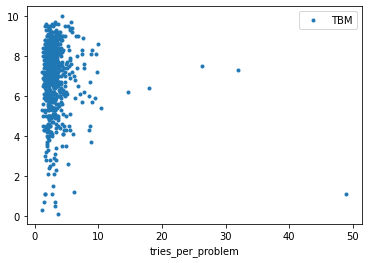

In [11]:
result2.plot(x='tries_per_problem', y='TBM', style='.',)

* **Nhận xét:** Dữ liệu trải đều trên miền điểm TBM nhưng ở miền lần thử/problem lại chỉ tập trung quanh đoạn [0 ; 5]

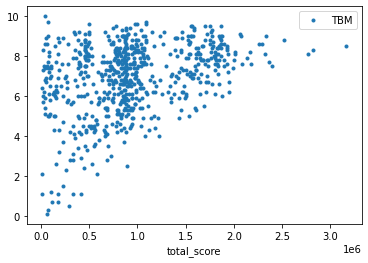

In [12]:
result2.plot(x='total_score', y='TBM', style='.', )

* **Nhận xét:** Các điểm dữ liệu tuy đã hình thành nên một đường thẳng tuyến tính mờ nhưng dữ liệu có giá trị TBM trong khoảng [4;9] lại tập trung nhiều quanh đoạn có giá trị total_score trong khoảng [0.75;1.1]

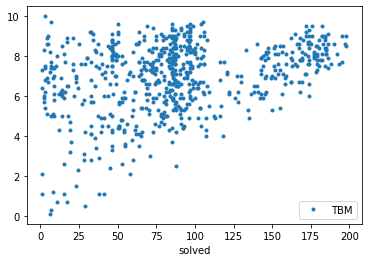

In [13]:
result2.plot(x='solved', y='TBM', style='.', )

* **Nhận xét:** Đường tuyến tính hình thành ở biểu đồ này có phần dày hơn tuy nhiên vẫn mở và điểm dữ liệu có giá trị TBM trong khoảng [4;10] vẫn tập trung nhiều quanh đoạn có giá trị solved trong khoảng [75;100]



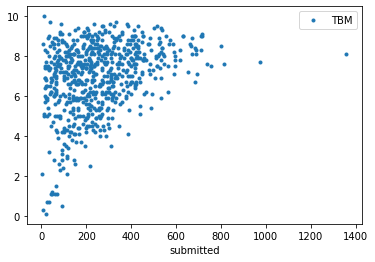

In [14]:
result2.plot(x='submitted', y='TBM', style='.', )

* **Nhận xét:** Đường tuyến tính ở biểu đồ này chỉ chứa một phần nhỏ số lượng điểm giá trị nếu so với lượng điểm giá trị nằm trong khoảng TBM [4;10] và submitted [0:600]

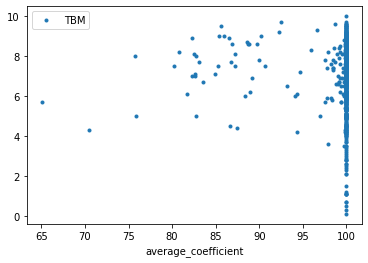

In [15]:
result2.plot(x='average_coefficient', y='TBM', style='.', )

* **Nhận xét:** Đa số các điểm dữ liệu tập trung ở miền average_coefficient có giá trị 100

#Phân tách dữ liệu và tiến hành dự đoán điểm

Lượng dữ liệu đã xác định điểm TBM

In [16]:
data_full = result2[result2["TBM"]>=0]
print("Data samples:" ,len(data_full['id']))
data_full.head(5)


Data samples: 674


,id,submitted,solved,tries_per_problem,average_coefficient,total_score,TBM
0,24,164,73,2.25,100.0,750299.0,9.4
1,27,13,3,4.33,100.0,39000.0,10.0
2,29,199,72,2.76,100.0,762760.0,8.2
4,35,297,141,2.11,100.0,1477000.0,6.2
5,37,312,93,3.35,100.0,979712.0,6.9


Lượng dữ liệu chưa xác định được điểm TBM

In [17]:
data_miss = result2[result2['TBM'].isna()]
print("Data samples:" ,len(data_miss['id']))
data_miss.head(5)

Data samples: 168


,id,submitted,solved,tries_per_problem,average_coefficient,total_score,TBM
3,34,218,81,2.69,100.0,822888.0,NaN
7,41,110,62,1.77,100.0,636888.0,NaN
10,45,161,55,2.93,100.0,601388.0,NaN
11,47,186,66,2.82,100.0,666000.0,NaN
12,48,26,19,1.37,100.0,225285.0,NaN


Để xây dựng model ta sử dụng 2 thông số trích xuất được từ data là tổng điểm wecode đạt được và số problem đã giải được

In [18]:
totalScore = data_full['total_score'].to_numpy()
solved = data_full['solved'].to_numpy()

totalScore = np.reshape(totalScore, (len(totalScore), 1))
solved = np.reshape(solved, (len(solved), 1))

x = np.append(totalScore, solved, axis=1)
y = data_full['TBM'].to_numpy()

#Tập dữ liệu train model
x_train = x[:500]
y_train = y[:500] 

#Tập dữ liệu test model
x_test = x[500:]
y_test = y[500:]

In [19]:
lr = LinearRegression().fit(x_train,y_train)

pre1 = lr.predict(x_train)
pre2 = lr.predict(x_test)
print("Score và MSE khi tiến hành dự đoán trên bộ dữ liệu train")
print("Score: ", lr.score(x_train, y_train))
print("MSE: ", mean_squared_error(y_train, pre1))
print()
print("Score và MSE khi tiến hành dự đoán trên bộ dữ liệu test")
print("Score: ", lr.score(x_test, y_test))
print("MSE: ", mean_squared_error(y_test, pre2))

Score và MSE khi tiến hành dự đoán trên bộ dữ liệu train
Score:  0.1006863986081994
MSE:  2.5613652490884498

Score và MSE khi tiến hành dự đoán trên bộ dữ liệu test
Score:  0.16888647748738816
MSE:  2.999685418281849


So sánh điểm TBM gốc và TBM sau khi dự đoán bằng model

In [30]:
TBM_predict = np.append(pre1, pre2)

TBM_data = [data_full["id"], data_full["TBM"]]
headers = ["id", "TBM"]
TBM = pd.concat(TBM_data, axis=1, keys=headers)

TBM['TBM_pre'] = pd.Series(TBM_predict, index=TBM.index)
TBM.head(20)

,id,TBM,TBM_pre
0,24,9.4,6.729310
1,27,10.0,6.071557
2,29,8.2,6.753794
4,35,6.2,7.421773
5,37,6.9,6.956455
6,40,8.6,7.750451
8,42,8.5,7.871704
9,43,7.2,7.791764
13,49,5.9,6.940492
15,52,5.6,6.936090
